In [1]:
import pandas as pd
import numpy as np
import os

In [3]:
import sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
from dataprocessor import *

/Users/feifang/miniconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/feifang/miniconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/feifang/miniconda3/envs/snorkel/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/feifang/miniconda3/envs/sno

## Load test set

In [5]:
processor = ImdbProcessor('../imdb-data')
test_examples = processor.get_test_examples()

In [6]:
labels_test_str = [example.label for example in test_examples]
labels_test = [1 if l == 'pos' else 0 for l in labels_test_str]

In [91]:
def read_tsv(input_file):
    """Reads a tab separated value file."""
    with tf.gfile.Open(input_file, "r") as f:
        reader = csv.reader(f, delimiter="\t")
        lines = []
        for line in reader:
            #line = [float(l) for l in line]
            lines.append(float(line[0]))
    return lines

In [92]:
def get_probs(train_set):
    model_id = models[train_set]
    pred_dir = 'gs://cs229-checkpoints/imdb/{}/{}'.format(train_set, model_id)
    pred_file = os.path.join(pred_dir, "preds_on_test.tsv")
    pred_probs = read_tsv(pred_file)
    return np.asarray(pred_probs)

In [186]:
def get_preds(probs):
    return (probs > 0.5).astype(int)

In [178]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_accuracy(preds):
    return accuracy_score(labels_test, preds)

def get_auc(probs):
    return roc_auc_score(labels_test, probs)

## Load predictions

In [187]:
models = {'sd800':'12111237',
          'wd05':"12131001",#'12130938',
          'og':'12111747',
          'sd1600':'12112209',
          'sd3200':'12112246',
          'sd6400':'12112338',
          'sd12800':'12120118',
         }

In [188]:
probs_dict = {}
preds_dict = {}
for train_set in models.keys():
    probs_dict[train_set] = get_probs(train_set)
    preds_dict[train_set] = get_preds(probs_dict[train_set])

## AUC

In [185]:
auc_dict = {}
for train_set in sorted(probs_dict.keys()):
    auc_score = get_auc(probs_dict[train_set])
    auc_dict[train_set] = auc_score
    print("AUC on {}: {}".format(train_set, auc_score))

AUC on og: 0.9742761560002732
AUC on sd12800: 0.9713277235161534
AUC on sd1600: 0.953066976299433
AUC on sd3200: 0.9620578580698039
AUC on sd6400: 0.9656495765316577
AUC on sd800: 0.9462379550577146
AUC on wd05: 0.9319446246841062


## Plot

In [190]:
ds_map = {i: 'sd' + str(i) for i in [800, 1600, 3200, 6400, 12800]}

In [191]:
ds_map[25000] = 'og'

In [192]:
import matplotlib.pyplot as plt

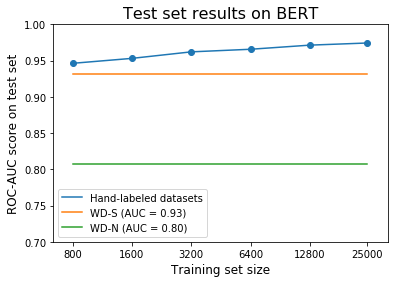

In [195]:
xs = [ds_size / 800 for ds_size in list(ds_map.keys())]
aucs = [auc_dict[ds_map[ds * 800]] for ds in xs]
plt.xscale("log", basex=2)
plt.ylim(0.7,1.)
plt.xlim(0.8, 40)
plt.xticks(xs, list(ds_map.keys()))
plt.scatter(xs, aucs)
plt.plot(xs, aucs, label='Hand-labeled datasets')
plt.xlabel("Training set size", fontsize=12)
plt.ylabel("ROC-AUC score on test set", fontsize=12)
plt.plot(np.linspace(1, 25000/800, 30), [auc_dict['wd05']] * 30, label="WD-S (AUC = 0.93)")
plt.plot(np.linspace(1, 25000/800, 30), [0.8069924936821256] * 30, label="WD-N (AUC = 0.80)")
plt.title("Test set results on BERT", fontsize=16)
plt.legend()

In [197]:
lstm_auc_dict = {
 'og': 0.9388325865719553,
 'sd12800': 0.9106639710402294,
 'sd1600': 0.8182989037634042,
 'sd3200': 0.8668804624001092,
 'sd6400': 0.8857327231746465,
 'sd800': 0.7997171026569223}

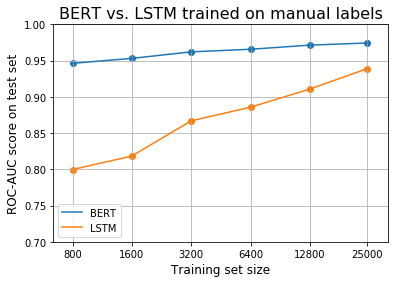

In [201]:
xs = [ds_size / 800 for ds_size in list(ds_map.keys())]
aucs = [auc_dict[ds_map[ds * 800]] for ds in xs]
lstm_aucs = [lstm_auc_dict[ds_map[ds * 800]] for ds in xs]
plt.xscale("log", basex=2)
plt.ylim(0.7,1.)
plt.xlim(0.8, 40)
plt.xticks(xs, list(ds_map.keys()))
plt.scatter(xs, aucs)
plt.plot(xs, aucs, label='BERT')
plt.scatter(xs, lstm_aucs)
plt.plot(xs, lstm_aucs, label="LSTM")
plt.xlabel("Training set size", fontsize=12)
plt.ylabel("ROC-AUC score on test set", fontsize=12)
plt.title("BERT vs. LSTM trained on manual labels", fontsize=16)
plt.legend()
plt.grid(True)

## Load dev for wd

In [152]:
dev_examples = processor.get_dev_examples()
labels_dev_str = [example.label for example in dev_examples]
labels_dev = [1 if l == 'pos' else 0 for l in labels_dev_str]

In [153]:
len(labels_dev)

800

In [154]:
def get_dev_probs(train_set, model_id):
    pred_dir = 'gs://cs229-checkpoints/imdb/{}/{}'.format(train_set, model_id)
    pred_file = os.path.join(pred_dir, "preds_on_dev.tsv")
    pred_probs = read_tsv(pred_file)
    return np.asarray(pred_probs)

In [155]:
dev_probs = get_dev_probs('wd05', '12130308')


In [156]:
dev_preds = get_preds(dev_probs)

In [157]:
accuracy_score(labels_dev, dev_preds)

0.5

In [158]:
roc_auc_score(labels_dev, dev_probs)

0.5768562500000001

In [160]:
dev_probs

array([0.03602624, 0.03579515, 0.03583509, 0.03581762, 0.03599897,
       0.03575489, 0.03585634, 0.03577894, 0.03596672, 0.03591129,
       0.03593579, 0.03568789, 0.03579429, 0.03581434, 0.03579786,
       0.03595662, 0.03592551, 0.03601733, 0.03595608, 0.03551084,
       0.03602675, 0.03572279, 0.03582311, 0.03580698, 0.03583255,
       0.03585321, 0.03580171, 0.03595027, 0.03573543, 0.03587651,
       0.03599292, 0.035759  , 0.03601405, 0.03573692, 0.03604165,
       0.03576606, 0.03603959, 0.03602257, 0.03572494, 0.03594768,
       0.03597525, 0.03592712, 0.03599435, 0.03572226, 0.03593504,
       0.03601185, 0.03593197, 0.035761  , 0.03545508, 0.03579852,
       0.0360156 , 0.03578335, 0.03588372, 0.0356473 , 0.03579712,
       0.03595579, 0.03572038, 0.03597096, 0.03592727, 0.03592187,
       0.03559759, 0.03607327, 0.03617838, 0.0358651 , 0.0358237 ,
       0.03591624, 0.03592497, 0.03597629, 0.0358938 , 0.03598106,
       0.0359107 , 0.03597447, 0.03587547, 0.03600943, 0.03587